In [1]:
#!/usr/bin/env Rscript
# ===================== 1) PACKAGES & UTILS =====================
quiet_install <- function(pkgs){
  need <- pkgs[!pkgs %in% rownames(installed.packages())]
  if (length(need)) install.packages(need, quiet = TRUE, dependencies = TRUE)
}
quiet_install(c("lavaan","dplyr","stringr","readr","DiagrammeR",
                "DiagrammeRsvg","svglite","knitr","rsvg"))

suppressPackageStartupMessages({
  library(lavaan); library(dplyr); library(stringr); library(readr)
  library(DiagrammeR); library(DiagrammeRsvg); library(knitr); library(rsvg)
})

`%+%` <- function(a,b) paste0(a,b)
pstars <- function(p) ifelse(is.na(p),"",
                      ifelse(p<.001,"***",ifelse(p<.01,"**",ifelse(p<.05,"*",""))))
set.seed(1234)


In [2]:
# ===================== 2) CONFIG & HELPERS =====================
DATA_FILE <- "local_cdr_keep_after_attn.csv"
OUT_DIR   <- "out_sem_cdr"
FITS_DIR  <- file.path(OUT_DIR, "fits")
dir.create(FITS_DIR, showWarnings = FALSE, recursive = TRUE)

# --- Likert handling ---
convert_likert <- function(x){
  x <- trimws(as.character(x))
  lead <- stringr::str_match(x, "^([1-7])")[,2]
  out  <- suppressWarnings(as.numeric(ifelse(!is.na(lead), lead, x)))
  out[is.na(out)] <- NA_real_; out
}
as_ord_1to7 <- function(x, min_count = 5){
  v <- convert_likert(x); if (all(is.na(v))) return(NULL)
  v <- pmin(pmax(round(v), 1), 7)
  tab <- table(v, useNA = "no")
  if ("1" %in% names(tab) && tab["1"] < min_count) v[v==1] <- 2
  tab <- table(v, useNA = "no")
  if ("7" %in% names(tab) && tab["7"] < min_count) v[v==7] <- 6
  if (length(unique(na.omit(v))) < 2) return(NULL)
  ordered(v, levels = sort(unique(v)))
}

# --- Fit table row + saving ---
fit_row <- function(m, label, n_fallback = NA_integer_){
  ks <- c("chisq","df","pvalue","cfi","tli","rmsea","rmsea.ci.lower","rmsea.ci.upper","srmr","nobs")
  vals <- sapply(ks, function(k){
    out <- tryCatch(fitMeasures(m, k), error=function(e) NA_real_)
    if (length(out)==0) NA_real_ else as.numeric(out)
  })
  if (is.na(vals["nobs"])) vals["nobs"] <- tryCatch(nobs(m), error=function(e) n_fallback)
  data.frame(
    Model = label,
    CHISQ = vals["chisq"], DF = vals["df"], PVALUE = vals["pvalue"],
    CFI = vals["cfi"], TLI = vals["tli"], SRMR = vals["srmr"],
    RMSEA = vals["rmsea"], RMSEA.CI.LOWER = vals["rmsea.ci.lower"], RMSEA.CI.UPPER = vals["rmsea.ci.upper"],
    NOBS = vals["nobs"], check.names = FALSE
  )
}

save_tbl <- function(df, stem){
  csv <- file.path(FITS_DIR, paste0(stem, ".csv"))
  md  <- file.path(FITS_DIR, paste0(stem, ".md"))
  readr::write_csv(df, csv)
  writeLines(paste(capture.output(knitr::kable(df, format="markdown")), collapse="\n"), md, useBytes=TRUE)
  invisible(list(csv=csv, md=md))
}

# --- Dump ALL parameter estimates (so Jupyter can show “all coefficients”) ---
save_all_params <- function(m, stem){
  PE <- parameterEstimates(m, standardized = TRUE, ci = TRUE)
  PE <- PE %>%
    mutate(stars = pstars(pvalue))
  readr::write_csv(PE, file.path(FITS_DIR, paste0("params_", stem, ".csv")))
  invisible(PE)
}


In [10]:
# ===================== FIXED draw_svg() =====================
draw_svg <- function(m, title, stem,
                     palette = list(
                       CDR           = "#89b4fa",
                       Environmental = "#a6e3a1",
                       Social        = "#f9e2af",
                       Governance    = "#cba6f7",
                       Indicator     = "#f5f5f5",
                       Pred_ENV      = "#94e2d5",
                       Pred_SOC      = "#f5c2e7",
                       Pred_DIGI     = "#fab387"
                     ),
                     png_width = 2200, png_height = 1800){

  SS <- standardizedSolution(m)
  PE <- parameterEstimates(m, standardized = TRUE)

  lats <- unique(c(SS$lhs[SS$op=="=~"], SS$rhs[SS$op=="=~" & SS$lhs=="CDR"]))
  inds <- setdiff(unique(SS$rhs[SS$op=="=~"]), lats)

  keepm <- function(d1, d2) merge(d1, d2, by = c("lhs","op","rhs"), all.x = TRUE)

  L <- keepm(unique(SS[SS$op=="=~", c("lhs","op","rhs","est.std")]),
             PE[PE$op=="=~", c("lhs","op","rhs","pvalue")])

  R <- keepm(unique(SS[SS$op=="~",  c("lhs","op","rhs","est.std")]),
             PE[PE$op=="~",  c("lhs","op","rhs","pvalue")])

  C <- keepm(unique(SS[SS$op=="~~" & SS$lhs %in% lats & SS$rhs %in% lats & SS$lhs < SS$rhs,
                       c("lhs","op","rhs","est.std")]),
             PE[PE$op=="~~", c("lhs","op","rhs","pvalue")])

  rhs_all <- unique(R$rhs)
  preds_observed <- setdiff(rhs_all, c(lats, inds))

  R2 <- tryCatch(inspect(m,"r2"), error=function(e) NULL)
  r2_for <- function(nm){
    if (is.null(R2)) return(NA_real_)
    if (is.numeric(R2) && !is.null(names(R2)) && nm %in% names(R2)) as.numeric(R2[[nm]])
    else if (is.list(R2) && nm %in% names(R2)) as.numeric(R2[[nm]]) else NA_real_
  }

  fmt  <- function(x) ifelse(is.finite(x), sprintf("%.2f", x), "–")
  star <- function(p) pstars(p)
  pen  <- function(p) ifelse(!is.na(p) & p < .05, 2.2, 1.2)

  label_map <- c("ENV_CONS"="Environmental Consciousness",
                 "SOC_CONS"="Social Consciousness",
                 "digiQ_prop"="Digital Competence")
  pretty <- function(x) ifelse(x %in% names(label_map), label_map[[x]], x)

  lat_col <- function(nm){
    if (nm=="CDR") palette$CDR else if (nm=="Environmental") palette$Environmental
    else if (nm=="Social") palette$Social else if (nm=="Governance") palette$Governance
    else if (nm=="ENV_CONS") palette$Pred_ENV else if (nm=="SOC_CONS") palette$Pred_SOC
    else "#eef5ff"
  }
  pred_col <- function(nm) if (nm=="digiQ_prop") palette$Pred_DIGI else "#e0e0e0"

  node_lat <- if (length(lats)) paste(sprintf('"%s" [label="%s\\nR² = %s", shape=box, style="rounded,filled", fillcolor="%s"];',
                    lats, sapply(lats, pretty), sapply(lats, function(n) fmt(r2_for(n))), sapply(lats, lat_col)), collapse="\n  ") else ""
  node_pred <- if (length(preds_observed)) paste(sprintf('"%s" [label="%s", shape=box, style="rounded,filled", fillcolor="%s"];',
                    preds_observed, sapply(preds_observed, pretty), sapply(preds_observed, pred_col)), collapse="\n  ") else ""
  node_ind <- if (length(inds)) paste(sprintf('"%s" [shape=ellipse, style="filled", fillcolor="%s"];',
                    inds, palette$Indicator), collapse="\n  ") else ""

  # --- Edges ---
  eL <- if (nrow(L)) paste(sprintf('"%s" -> "%s" [label="%s%s", penwidth=%.1f];',
                    L$lhs, L$rhs, fmt(L$est.std), star(L$pvalue), pen(L$pvalue)), collapse="\n  ") else ""

  # FIX: use R$pvalue (not L$pvalue) so vector lengths match
  eR <- if (nrow(R)) paste(sprintf('"%s" -> "%s" [label="%s%s", color="#333", penwidth=%.1f];',
                    R$rhs, R$lhs, fmt(R$est.std), star(R$pvalue), pen(R$pvalue)), collapse="\n  ") else ""

  # FIX: use C$pvalue (not L$pvalue)
  eC <- if (nrow(C)) paste(sprintf('"%s" -> "%s" [dir=none, label="%s%s", color="#88a", penwidth=%.1f];',
                    C$lhs, C$rhs, fmt(C$est.std), star(C$pvalue), pen(C$pvalue)), collapse="\n  ") else ""

  dot <- sprintf('digraph {
    graph [layout=dot, rankdir=TB, fontsize=12, labelloc="t", label="%s"];
    node  [fontname="Helvetica"];
    edge  [fontname="Helvetica"];
    %s
    %s
    %s
    %s
    %s
  }', title, node_lat, node_pred, node_ind, eL, eR %+% if (nchar(eC)) paste0("\n  ", eC) else "")

  g <- DiagrammeR::grViz(dot, engine="dot")
  svg <- file.path(OUT_DIR, paste0(stem, ".svg"))
  png <- file.path(OUT_DIR, paste0(stem, ".png"))
  writeLines(DiagrammeRsvg::export_svg(g), svg)
  rsvg::rsvg_png(svg, png, width=png_width, height=png_height)
  svg
}


In [11]:
# ===================== 4) FIT WITH RESCUE =====================
fit_with_rescue <- function(model_txt, data, ord_cols, label=""){
  ladder <- expand.grid(est=c("WLSMV","DWLS"), st=c(FALSE, TRUE),
                        KEEP.OUT.ATTRS=FALSE, stringsAsFactors=FALSE)
  for (k in seq_len(nrow(ladder))) {
    est <- ladder$est[k]; st <- ladder$st[k]
    cat(sprintf("\n[%s] Trying: est=%s, theta, start_simple=%s\n", label, est, st))
    fit <- try(lavaan::sem(
      model            = model_txt,
      data             = data,
      ordered          = ord_cols,
      estimator        = est,
      parameterization = "theta",
      std.lv           = FALSE,        # marker-ID
      missing          = "listwise",
      start            = if (st) "simple" else NULL,
      control          = list(iter.max = 10000, rel.tol = 1e-6)
    ), silent = TRUE)
    ok <- !inherits(fit,"try-error") && isTRUE(tryCatch(lavInspect(fit,"converged"), error=function(e) FALSE))
    if (ok) { cat("Converged: TRUE\n"); return(fit) } else { cat("Converged: FALSE\n") }
  }
  stop(sprintf("All rescue attempts failed (%s).", label))
}


In [12]:
# ===================== 5) READ & ASSEMBLE DATA =====================
stopifnot(file.exists(DATA_FILE))
cat("Reading:", normalizePath(DATA_FILE), "\n")
raw0 <- readr::read_csv(DATA_FILE, show_col_types=FALSE) |> as.data.frame()

# Keep original names for reporting, but sanitize for lavaan
orig_names <- names(raw0)
safe_names <- make.names(orig_names)
if (!identical(orig_names, safe_names)) names(raw0) <- safe_names
name_map <- setNames(orig_names, safe_names)  # safe -> original

# CDR item columns (ENV/SOC/GOV_01..)
cdr_cols <- grep("^(ENV|SOC|GOV)_\\d{2}$", names(raw0), value=TRUE)

# Fallback tolerant mapping if not present
tolerant_map <- function(){
  out <- vector("list", 20); names(out) <- as.character(1:20)
  for (i in 1:20) {
    pat <- paste0("^", make.names(paste0("CDR attributions _", i)), "$")
    hit <- grep(pat, names(raw0), value=TRUE)
    if (length(hit)) out[[as.character(i)]] <- hit[1]
  }
  out
}
if (length(cdr_cols) < 6) {
  m <- tolerant_map()
  if (!length(Filter(Negate(is.null), m))) stop("Provide ENV_01..GOV_20 or 'CDR attributions _1..20'.")
  tag_from_num <- function(i){ if (i<=3) sprintf("ENV_%02d", i) else if (i<=12) sprintf("SOC_%02d", i) else sprintf("GOV_%02d", i) }
  X <- data.frame(row_id=seq_len(nrow(raw0)))
  for (i in 1:20){ src <- m[[as.character(i)]]; if (!is.null(src)) X[[tag_from_num(i)]] <- raw0[[src]] }
  X$row_id <- NULL
} else {
  X <- raw0[, cdr_cols, drop=FALSE]
}

# Predictor indicators (names already sanitized)
ENV_ITEMS <- grep("^CDR.pred..*envconsc_([1-4])$", names(raw0), value=TRUE, ignore.case=TRUE)
SOC_ITEMS <- grep("^CDR.pred..*socconsc_([1-3])$", names(raw0), value=TRUE, ignore.case=TRUE)
digi_col  <- grep("^digiQ_prop$", names(raw0), value=TRUE, ignore.case=TRUE)
if (!length(digi_col)) { warning("digiQ_prop not found; creating NA."); raw0$digiQ_prop <- NA_real_; digi_col <- "digiQ_prop" }
stopifnot(length(ENV_ITEMS) >= 2, length(SOC_ITEMS) >= 2)

# Convert Likert -> ordered, drop weak columns
XO <- lapply(X, as_ord_1to7)
keep <- !vapply(XO, is.null, logical(1))
if (!all(keep)) message("Dropped ESG items with <2 categories: ", paste(names(XO)[!keep], collapse=", "))
X2 <- as.data.frame(XO[keep], check.names=FALSE)

ITEMS <- list(
  Environmental = grep("^ENV_\\d{2}$", names(X2), value=TRUE),
  Social        = grep("^SOC_\\d{2}$", names(X2), value=TRUE),
  Governance    = grep("^GOV_\\d{2}$", names(X2), value=TRUE)
)
for (nm in names(ITEMS)) if (length(ITEMS[[nm]]) < 2) stop("Identification issue: ", nm, " has <2 indicators.")

DF <- cbind(
  X2,
  ENV_CONS_1 = raw0[[ENV_ITEMS[1]]], ENV_CONS_2 = raw0[[ENV_ITEMS[2]]],
  ENV_CONS_3 = if (length(ENV_ITEMS) >= 3) raw0[[ENV_ITEMS[3]]] else NA,
  ENV_CONS_4 = if (length(ENV_ITEMS) >= 4) raw0[[ENV_ITEMS[4]]] else NA,
  SOC_CONS_1 = raw0[[SOC_ITEMS[1]]],  SOC_CONS_2 = raw0[[SOC_ITEMS[2]]],
  SOC_CONS_3 = if (length(SOC_ITEMS) >= 3) raw0[[SOC_ITEMS[3]]] else NA,
  digiQ_prop = suppressWarnings(as.numeric(raw0[[digi_col]]))
)
for (j in c("ENV_CONS_1","ENV_CONS_2","ENV_CONS_3","ENV_CONS_4","SOC_CONS_1","SOC_CONS_2","SOC_CONS_3"))
  if (j %in% names(DF)) DF[[j]] <- as_ord_1to7(DF[[j]])

ENV_CONS_IND <- intersect(c("ENV_CONS_1","ENV_CONS_2","ENV_CONS_3","ENV_CONS_4"),
                          names(DF)[vapply(DF, is.ordered, logical(1))])
SOC_CONS_IND <- intersect(c("SOC_CONS_1","SOC_CONS_2","SOC_CONS_3"),
                          names(DF)[vapply(DF, is.ordered, logical(1))])

ordered_cols <- names(DF)[vapply(DF, is.ordered, logical(1))]
if (is.numeric(DF$digiQ_prop)) DF$digiQ_prop <- as.numeric(scale(DF$digiQ_prop, center=TRUE, scale=TRUE))


Reading: /home/akroon/corporate-digital-responsibility/local_cdr_keep_after_attn.csv 


In [28]:
# ===================== 6) MODEL BUILDERS =====================
meas_1st <- function(items){
  sprintf(paste0(
    "Environmental =~ 1*%s + %s\n",
    "Social        =~ 1*%s + %s\n",
    "Governance    =~ 1*%s + %s\n",
    "Environmental ~~ v_env*Environmental\n",
    "Social        ~~ v_soc*Social\n",
    "Governance    ~~ v_gov*Governance\n"),
    items$Environmental[1], paste(setdiff(items$Environmental, items$Environmental[1]), collapse=" + "),
    items$Social[1],         paste(setdiff(items$Social,         items$Social[1]),         collapse=" + "),
    items$Governance[1],     paste(setdiff(items$Governance,     items$Governance[1]),     collapse=" + "))
}
meas_2nd  <- "CDR =~ 1*Social + Environmental + Governance\n"
meas_pred <- paste0(
  "ENV_CONS =~ 1*", ENV_CONS_IND[1], if (length(ENV_CONS_IND)>1) paste0(" + ", paste(ENV_CONS_IND[-1], collapse=" + ")) else "", "\n",
  "SOC_CONS =~ 1*", SOC_CONS_IND[1], if (length(SOC_CONS_IND)>1) paste0(" + ", paste(SOC_CONS_IND[-1], collapse=" + ")) else "", "\n"
)
ridge_constr <- "v_env > 1e-6\nv_soc > 1e-6\nv_gov > 1e-6\n"

# Ambiguous SOC items to move/drop
SOC_TO_GOV <- c("SOC_05","SOC_09","SOC_11","SOC_12")

items_theory   <- ITEMS
items_shift    <- ITEMS; items_shift$Social <- setdiff(items_shift$Social, SOC_TO_GOV)
items_shift$Governance <- sort(unique(c(items_shift$Governance, SOC_TO_GOV)))
items_drop     <- ITEMS; items_drop$Social <- setdiff(items_drop$Social, SOC_TO_GOV)

model_2ND_core <- function(items) paste0(
  meas_1st(items), meas_2nd, meas_pred,
  "CDR ~ ENV_CONS + SOC_CONS + digiQ_prop\n",
  ridge_constr
)

# Non-moderated domain-paths model (RQ3.1): adds domain arrows, no trust terms
model_2ND_domainPaths <- function(items) paste0(
  meas_1st(items), meas_2nd, meas_pred,
  # domain-specific paths (no moderation here)
  "Environmental ~ ENV_CONS\n",
  "Social        ~ SOC_CONS\n",
  # higher-order CDR paths (as in core)
  "CDR ~ ENV_CONS + SOC_CONS + digiQ_prop\n",
  ridge_constr
)



In [29]:
# ===================== 7) FIT CORE VARIANTS =====================

# Build the set of NON-moderated models to fit (RQ3.1 only)
M_txt <- list(
  SEM_2ND_theory_core           = model_2ND_core(items_theory),
  # SEM_2ND_EFAshift_core       = model_2ND_core(items_shift),   # <- keep commented if you don't want it
  SEM_2ND_dropAmbig_core        = model_2ND_core(items_drop),
  # NEW: domain-paths (no trust moderation) for RQ3.1
  SEM_2ND_dropAmbig_domainPaths = model_2ND_domainPaths(items_drop)
)

fits   <- list()
fitsum <- list()

for (nm in names(M_txt)) {
  cat("\n[ SEM ] Fitting", nm, "...\n")
  fits[[nm]]   <- fit_with_rescue(M_txt[[nm]], DF, ordered_cols, label = nm)
  fitsum[[nm]] <- fit_row(fits[[nm]], nm, n_fallback = nrow(DF))
}

# Bind & save comparison table
fit_table <- dplyr::bind_rows(fitsum)
cat("\n\n## SEM model comparison\n")
print(knitr::kable(fit_table, format = "markdown"))
save_tbl(fit_table, "sem_compare_all")



[ SEM ] Fitting SEM_2ND_theory_core ...

[SEM_2ND_theory_core] Trying: est=WLSMV, theta, start_simple=FALSE
Converged: TRUE

[ SEM ] Fitting SEM_2ND_dropAmbig_core ...

[SEM_2ND_dropAmbig_core] Trying: est=WLSMV, theta, start_simple=FALSE
Converged: TRUE

[ SEM ] Fitting SEM_2ND_dropAmbig_domainPaths ...

[SEM_2ND_dropAmbig_domainPaths] Trying: est=WLSMV, theta, start_simple=FALSE
Converged: TRUE


## SEM model comparison


|          |Model                         |    CHISQ|  DF| PVALUE|       CFI|       TLI|      SRMR|     RMSEA| RMSEA.CI.LOWER| RMSEA.CI.UPPER| NOBS|
|:---------|:-----------------------------|--------:|---:|------:|---------:|---------:|---------:|---------:|--------------:|--------------:|----:|
|chisq...1 |SEM_2ND_theory_core           | 3173.095| 344|      0| 0.9942496| 0.9941326| 0.0409334| 0.0611689|      0.0592302|      0.0631264| 2199|
|chisq...2 |SEM_2ND_dropAmbig_core        | 2280.910| 246|      0| 0.9935410| 0.9933572| 0.0392177| 0.0613467|      0.059056

In [31]:
# ===================== 8) EXPORTS PER MODEL =====================
for (nm in names(fits)){
  m <- fits[[nm]]

  # ---- Structural paths ----
  PE <- parameterEstimates(m, standardized = TRUE, ci = TRUE)

  # Detect if this is the moderated model (predictor names contain *_obs or *xTRUST or TRUST_c)
  is_mod <- any(grepl("(_obs|xTRUST|TRUST_c)$", PE$rhs))

  if (!is_mod) {
    # Regular models: keep only ENV_CONS, SOC_CONS, digiQ_prop (works for core + non-MOD domain-paths)
    paths <- PE %>%
      dplyr::filter(op == "~", rhs %in% c("ENV_CONS","SOC_CONS","digiQ_prop")) %>%
      dplyr::arrange(lhs) %>%
      dplyr::transmute(
        Outcome = lhs, Predictor = rhs, Est = est, SE = se, z = z, p = pvalue,
        Std = std.all, CI.L = ci.lower, CI.U = ci.upper, Stars = pstars(pvalue)
      )
    if (nrow(paths)){
      cat("\n###", nm, "\n\n")
      print(knitr::kable(paths, format = "markdown"))
      save_tbl(paths, paste0("paths_", nm))
    }
  } else {
    # Moderated model: export ALL structural paths so notebook can filter CDR/domain later
    paths_all <- PE %>%
      dplyr::filter(op == "~") %>%
      dplyr::arrange(lhs) %>%
      dplyr::transmute(
        Outcome = lhs, Predictor = rhs, Est = est, SE = se, z = z, p = pvalue,
        Std = std.all, CI.L = ci.lower, CI.U = ci.upper, Stars = pstars(pvalue)
      )
    if (nrow(paths_all)){
      cat("\n###", nm, "(all structural paths)\n\n")
      print(knitr::kable(paths_all, format = "markdown"))
      save_tbl(paths_all, paste0("paths_ALL_", nm))
    }
  }

  # ---- First-order loadings ----
  SS <- standardizedSolution(m)
  loads <- SS %>%
    dplyr::filter(op == "=~", !lhs %in% c("CDR")) %>%
    dplyr::transmute(Factor = lhs, Item = rhs, Std_Loading = est.std)
  if (nrow(loads)) save_tbl(loads, paste0("loads_", nm))

  # ---- Second-order loadings ----
  loads2 <- SS %>%
    dplyr::filter(op == "=~", lhs %in% c("CDR")) %>%
    dplyr::transmute(Higher = lhs, Lower = rhs, Std_Loading = est.std)
  if (nrow(loads2)) save_tbl(loads2, paste0("loads_second_", nm))

  # ---- Diagram ----
  draw_svg(m, nm, paste0("graph_", nm))

  # ---- Full parameter table (for deep-dive / reproducibility) ----
  if (exists("save_all_params")) save_all_params(m, nm)

  # ---- Fit statistics CSV per model (so the notebook can show fits per model) ----
  if (exists("save_fit_stats")) {
    try(save_fit_stats(m, nm), silent = TRUE)
  }
}

cat("\n✅ Done. All outputs in: ", normalizePath(OUT_DIR), "\n", sep = "")



### SEM_2ND_theory_core 



|Outcome |Predictor  |       Est|        SE|         z|         p|       Std|      CI.L|      CI.U|Stars |
|:-------|:----------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:-----|
|CDR     |ENV_CONS   | 0.5100545| 0.0373283| 13.664026| 0.0000000| 0.4411919| 0.4368925| 0.5832166|***   |
|CDR     |SOC_CONS   | 0.0706801| 0.0192095|  3.679427| 0.0002338| 0.1010259| 0.0330301| 0.1083301|***   |
|CDR     |digiQ_prop | 0.4464891| 0.0226668| 19.697911| 0.0000000| 0.4771164| 0.4020630| 0.4909153|***   |

### SEM_2ND_dropAmbig_core 



|Outcome |Predictor  |       Est|        SE|         z|        p|       Std|      CI.L|      CI.U|Stars |
|:-------|:----------|---------:|---------:|---------:|--------:|---------:|---------:|---------:|:-----|
|CDR     |ENV_CONS   | 0.5341269| 0.0385516| 13.854841| 0.00e+00| 0.4534838| 0.4585671| 0.6096868|***   |
|CDR     |SOC_CONS   | 0.0830100| 0.0211560|  3.923716| 8.72e-05| 0.1097379| 0.0415451

In [32]:
# ===================== 9) MODERATED MODEL (TRUST) =====================
# Helpers
make_composite <- function(cols, data) {
  if (length(cols) < 1) stop("No columns provided to make_composite().")
  mats <- lapply(cols, function(nm) {
    if (!nm %in% names(data)) stop("Column not found: ", nm)
    x <- data[[nm]]
    if (is.ordered(x) || is.factor(x)) convert_likert(x) else suppressWarnings(as.numeric(x))
  })
  M <- do.call(cbind, mats)
  as.numeric(rowMeans(M, na.rm = TRUE))
}

# Trust items after make.names(): "CDR.pred..trust_1" ... "_5"
TRUST_ITEMS <- grep("^CDR\\.pred\\.\\.trust_[1-5]$", names(raw0), value = TRUE)
if (length(TRUST_ITEMS) < 1) stop("No TRUST items found. Expected like 'CDR pred, trust_1'.")

TRUST_raw <- make_composite(TRUST_ITEMS, raw0)
TRUST_c   <- as.numeric(scale(TRUST_raw, center = TRUE, scale = TRUE))

# ENV/SOC composites from DF (ordered->numeric row means)
stopifnot(length(ENV_CONS_IND) >= 1, length(SOC_CONS_IND) >= 1)
ENV_CONS_obs <- as.numeric(scale(make_composite(ENV_CONS_IND, DF), center=TRUE, scale=TRUE))
SOC_CONS_obs <- as.numeric(scale(make_composite(SOC_CONS_IND, DF), center=TRUE, scale=TRUE))

# digiQ centered
if (!is.numeric(DF$digiQ_prop)) DF$digiQ_prop <- suppressWarnings(as.numeric(DF$digiQ_prop))
DF$digiQ_prop <- as.numeric(scale(DF$digiQ_prop, center = TRUE, scale = TRUE))

# Interactions
ENVxTRUST  <- ENV_CONS_obs * TRUST_c
SOCxTRUST  <- SOC_CONS_obs * TRUST_c
DIGIxTRUST <- DF$digiQ_prop * TRUST_c

# Bind
DF$TRUST_c      <- TRUST_c
DF$ENV_CONS_obs <- ENV_CONS_obs
DF$SOC_CONS_obs <- SOC_CONS_obs
DF$ENVxTRUST    <- ENVxTRUST
DF$SOCxTRUST    <- SOCxTRUST
DF$DIGIxTRUST   <- DIGIxTRUST

# Moderated model text
model_2ND_domainPaths_MOD <- function(items) paste0(
  meas_1st(items), meas_2nd,
  "Environmental ~ ENV_CONS_obs + ENVxTRUST\n",
  "Social        ~ SOC_CONS_obs + SOCxTRUST\n",
  "CDR ~ ENV_CONS_obs + SOC_CONS_obs + digiQ_prop + TRUST_c + ENVxTRUST + SOCxTRUST + DIGIxTRUST\n",
  ridge_constr
)

# Fit
mod_name <- "SEM_2ND_dropAmbig_domainPaths_MOD"
ordered_cols_now <- names(DF)[vapply(DF, is.ordered, logical(1))]
cat("\n[ SEM ] Fitting ", mod_name, " ...\n", sep = "")
m_mod <- fit_with_rescue(model_2ND_domainPaths_MOD(items_drop), DF, ordered_cols_now, label = mod_name)

# Fit stats table
keys <- c("chisq","df","pvalue","cfi","tli","rmsea","rmsea.ci.lower","rmsea.ci.upper","srmr",
          "cfi.robust","tli.robust","rmsea.robust","rmsea.ci.lower.robust","rmsea.ci.upper.robust",
          "scaled.chisq","scaled.df","scaled.pvalue","nobs")
getm <- function(mm, k) { out <- tryCatch(fitMeasures(mm, k), error=function(e) NA_real_); if (length(out)==0) NA_real_ else as.numeric(out) }
vals <- setNames(sapply(keys, function(k) getm(m_mod, k)), keys)
if (is.na(vals["nobs"])) vals["nobs"] <- tryCatch(nobs(m_mod), error=function(e) NA_real_)
fit_df <- data.frame(
  Model = mod_name,
  N     = vals["nobs"],
  Chisq = vals["chisq"], df = vals["df"], p = vals["pvalue"],
  CFI   = vals["cfi"],   TLI = vals["tli"],
  SRMR  = vals["srmr"],
  RMSEA = vals["rmsea"], RMSEA.L = vals["rmsea.ci.lower"], RMSEA.U = vals["rmsea.ci.upper"],
  CFI.rob = vals["cfi.robust"], TLI.rob = vals["tli.robust"],
  RMSEA.rob = vals["rmsea.robust"], RMSEA.rob.L = vals["rmsea.ci.lower.robust"], RMSEA.rob.U = vals["rmsea.ci.upper.robust"],
  Chisq.scaled = vals["scaled.chisq"], df.scaled = vals["scaled.df"], p.scaled = vals["scaled.pvalue"],
  check.names = FALSE
)
num_cols <- sapply(fit_df, is.numeric)
fit_df[num_cols] <- lapply(fit_df[num_cols], function(x) ifelse(is.na(x), NA, round(x, 6)))
save_tbl(fit_df, "sem_fit_moderated_only")

# Structural paths (all) + save
PEm <- parameterEstimates(m_mod, standardized=TRUE, ci=TRUE)
paths_all <- PEm[PEm$op=="~", c("lhs","op","rhs","est","se","z","pvalue","std.all","ci.lower","ci.upper")]
paths_all <- paths_all[order(paths_all$lhs, paths_all$rhs), ]
colnames(paths_all) <- c("Outcome","~","Predictor","Est","SE","z","p","Std","CI.L","CI.U")
save_tbl(paths_all, paste0("paths_ALL_", mod_name))

# Loadings + diagram + full params
SS <- standardizedSolution(m_mod)
loads1 <- subset(SS, op=="=~" & lhs!="CDR", select=c(lhs,rhs,est.std))
colnames(loads1) <- c("Factor","Item","Std_Loading"); if (nrow(loads1)) save_tbl(loads1, paste0("loads_", mod_name))
loads2 <- subset(SS, op=="=~" & lhs=="CDR", select=c(lhs,rhs,est.std))
colnames(loads2) <- c("Higher","Lower","Std_Loading"); if (nrow(loads2)) save_tbl(loads2, paste0("loads_second_", mod_name))

draw_svg(m_mod, mod_name, paste0("graph_", mod_name))
save_all_params(m_mod, mod_name)

cat("\n✅ Moderated model complete. Outputs in: ", normalizePath(OUT_DIR), "\n", sep="")


[ SEM ] Fitting SEM_2ND_dropAmbig_domainPaths_MOD ...

[SEM_2ND_dropAmbig_domainPaths_MOD] Trying: est=WLSMV, theta, start_simple=FALSE
Converged: TRUE


[1] "out_sem_cdr/graph_SEM_2ND_dropAmbig_domainPaths_MOD.svg"


✅ Moderated model complete. Outputs in: /home/akroon/corporate-digital-responsibility/out_sem_cdr


In [18]:
save_fit_stats <- function(m, name){
  keys <- c(
    "chisq","df","pvalue","cfi","tli","srmr","rmsea",
    "rmsea.ci.lower","rmsea.ci.upper",
    "cfi.robust","tli.robust","rmsea.robust",
    "rmsea.ci.lower.robust","rmsea.ci.upper.robust",
    "scaled.chisq","scaled.df","scaled.pvalue","nobs"
  )
  getm <- function(mm, k) {
    out <- tryCatch(fitMeasures(mm, k), error = function(e) NA_real_)
    if (length(out)==0) NA_real_ else as.numeric(out)
  }
  vals <- setNames(sapply(keys, function(k) getm(m, k)), keys)
  if (is.na(vals["nobs"])) vals["nobs"] <- tryCatch(nobs(m), error=function(e) NA_real_)
  fit_df <- as.data.frame(as.list(vals), check.names = FALSE)
  fit_df <- cbind(Model = name, fit_df)
  # round numerics for readability
  num_cols <- vapply(fit_df, is.numeric, logical(1))
  fit_df[num_cols] <- lapply(fit_df[num_cols], function(x) ifelse(is.na(x), NA, round(x, 6)))
  readr::write_csv(fit_df, file.path(FITS_DIR, paste0("fit_", name, ".csv")))
  invisible(fit_df)
}



————————————————————
  Model comparison
————————————————————



|Model                         |    CHISQ|  DF| PVALUE|   CFI|   TLI|  SRMR| RMSEA| RMSEA.CI.LOWER| RMSEA.CI.UPPER| NOBS|
|:-----------------------------|--------:|---:|------:|-----:|-----:|-----:|-----:|--------------:|--------------:|----:|
|SEM_2ND_theory_core           | 3173.095| 344|      0| 0.994| 0.994| 0.041| 0.061|          0.059|          0.063| 2199|
|SEM_2ND_dropAmbig_core        | 2280.910| 246|      0| 0.994| 0.993| 0.039| 0.061|          0.059|          0.064| 2199|
|SEM_2ND_dropAmbig_domainPaths | 1855.946| 244|      0| 0.995| 0.995| 0.034| 0.055|          0.053|          0.057| 2199|


—————————————————————————————————
  Full fit statistics per model
—————————————————————————————————

### SEM_2ND_theory_core 



|Model               |    chisq|  df| pvalue|   cfi|   tli|  srmr| rmsea| rmsea.ci.lower| rmsea.ci.upper|cfi.robust |tli.robust |rmsea.robust |rmsea.ci.lower.robust |rmsea.ci.upper.robust |scale

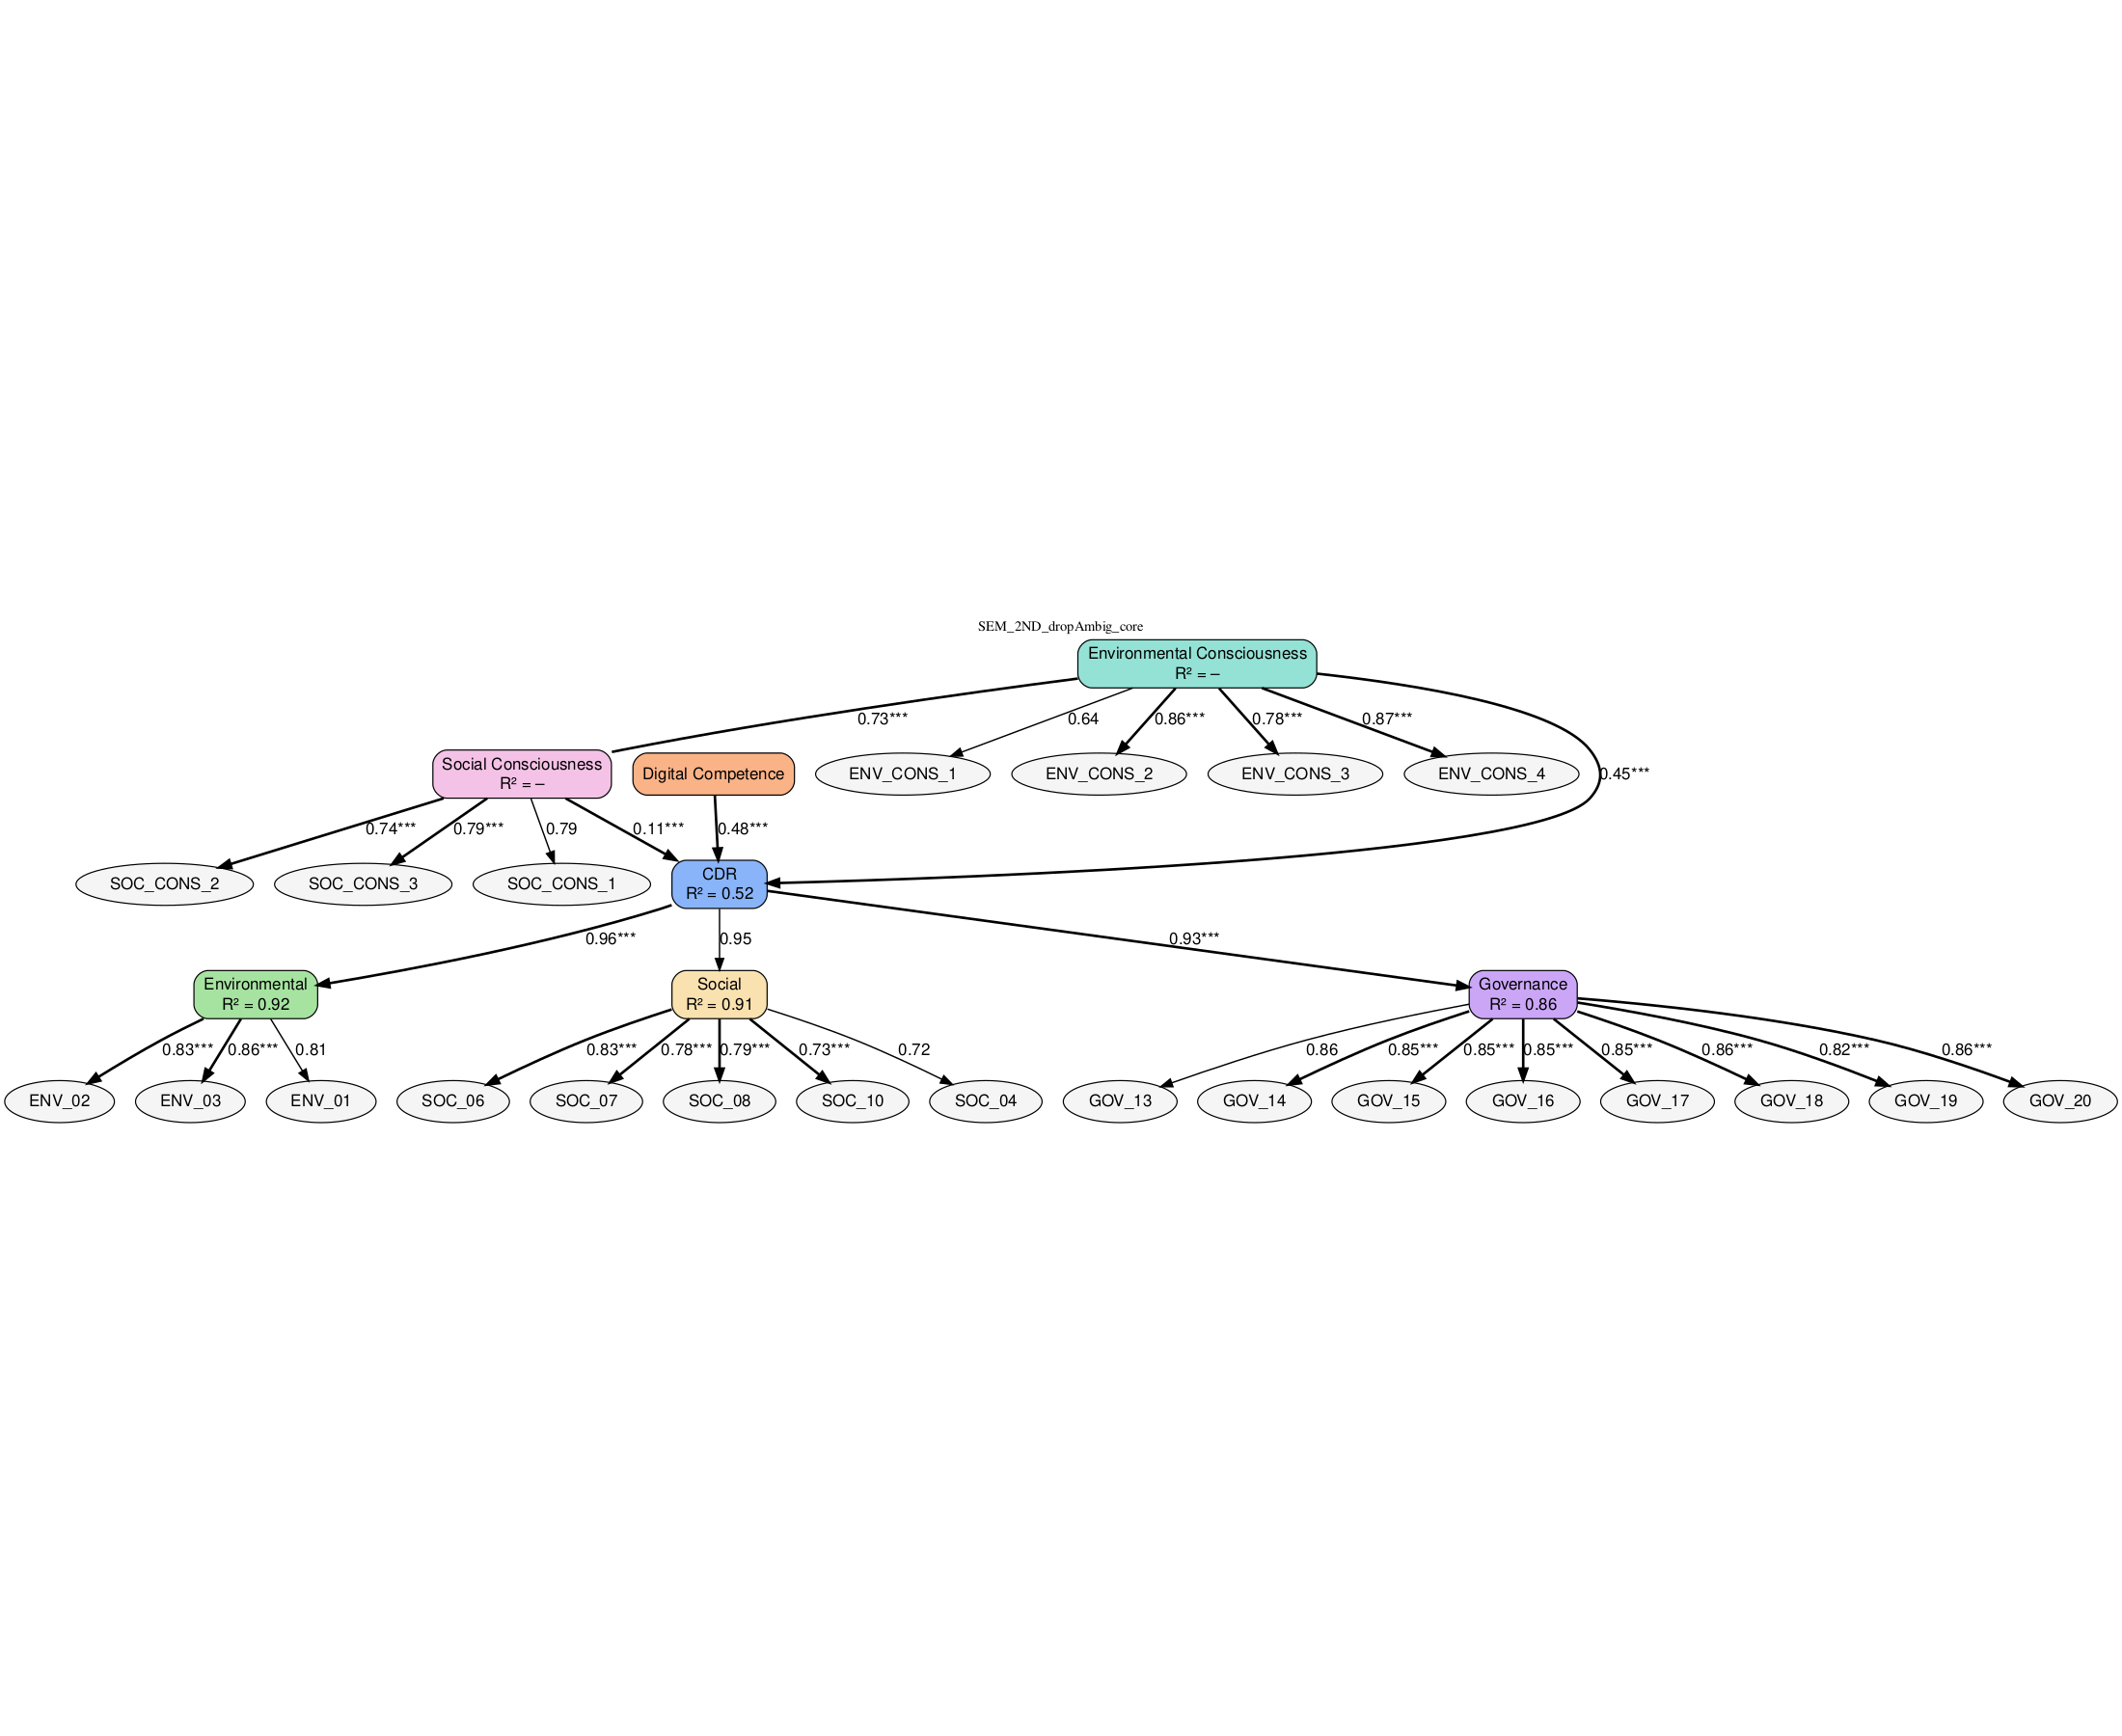

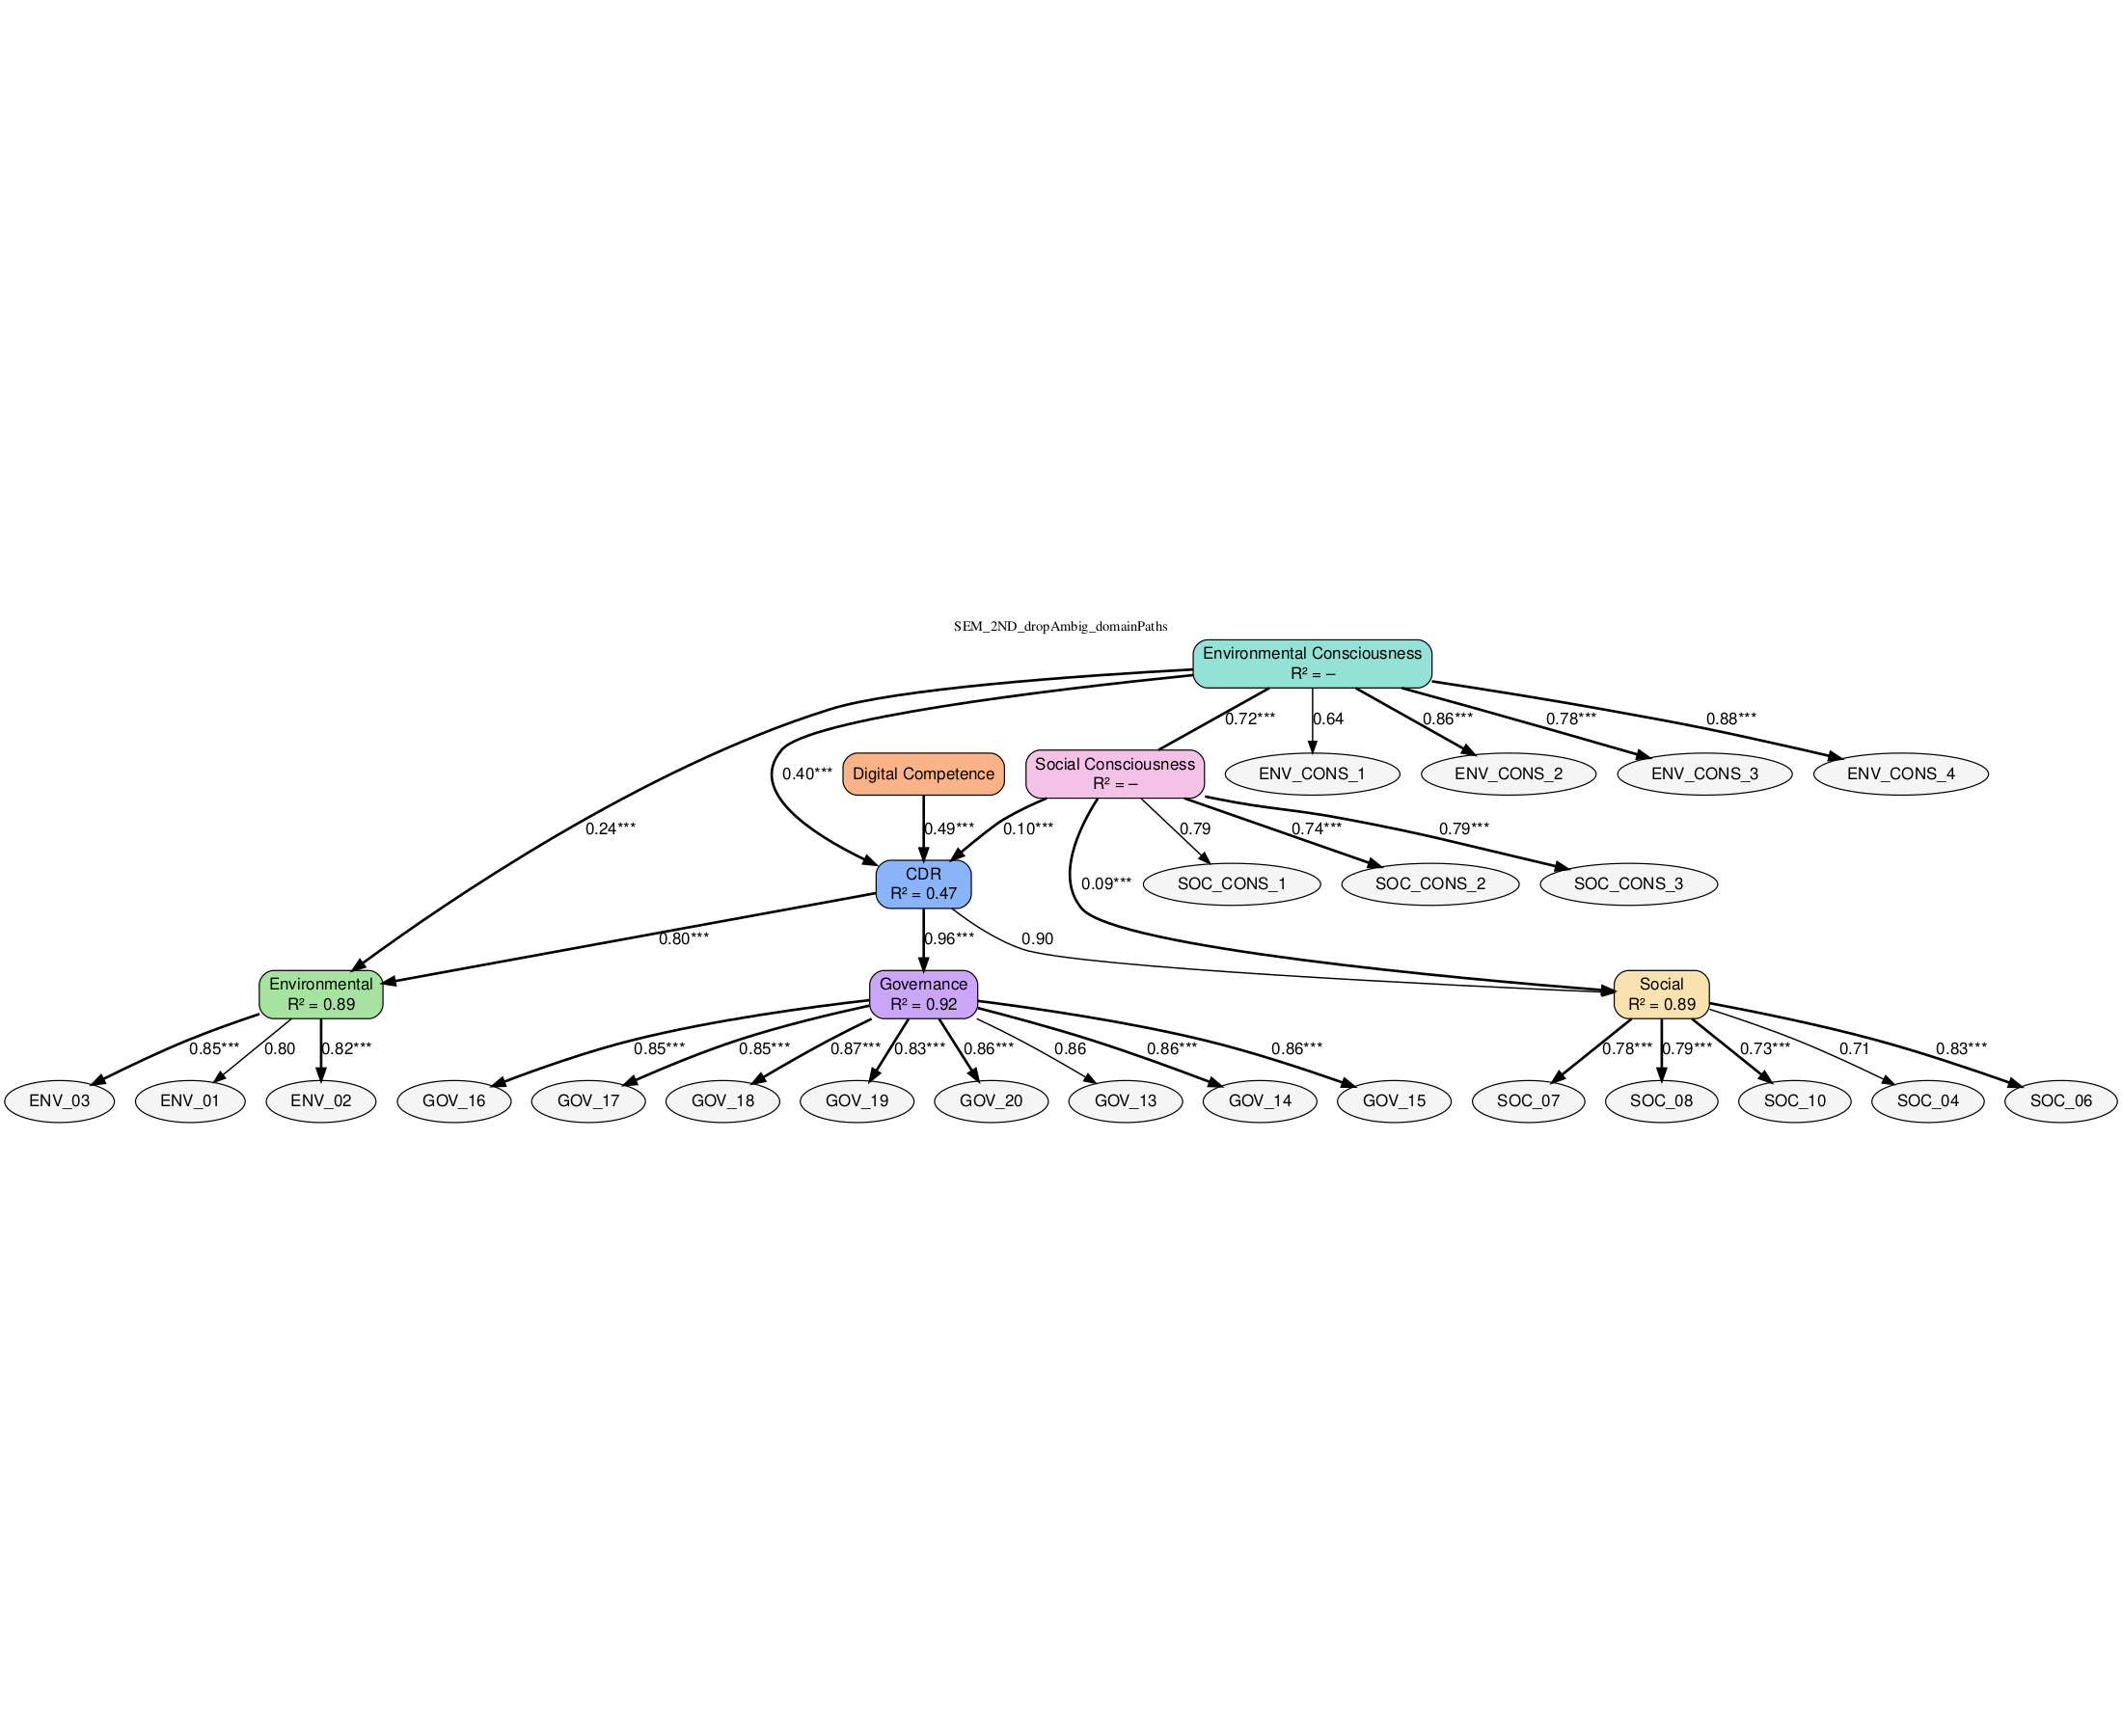

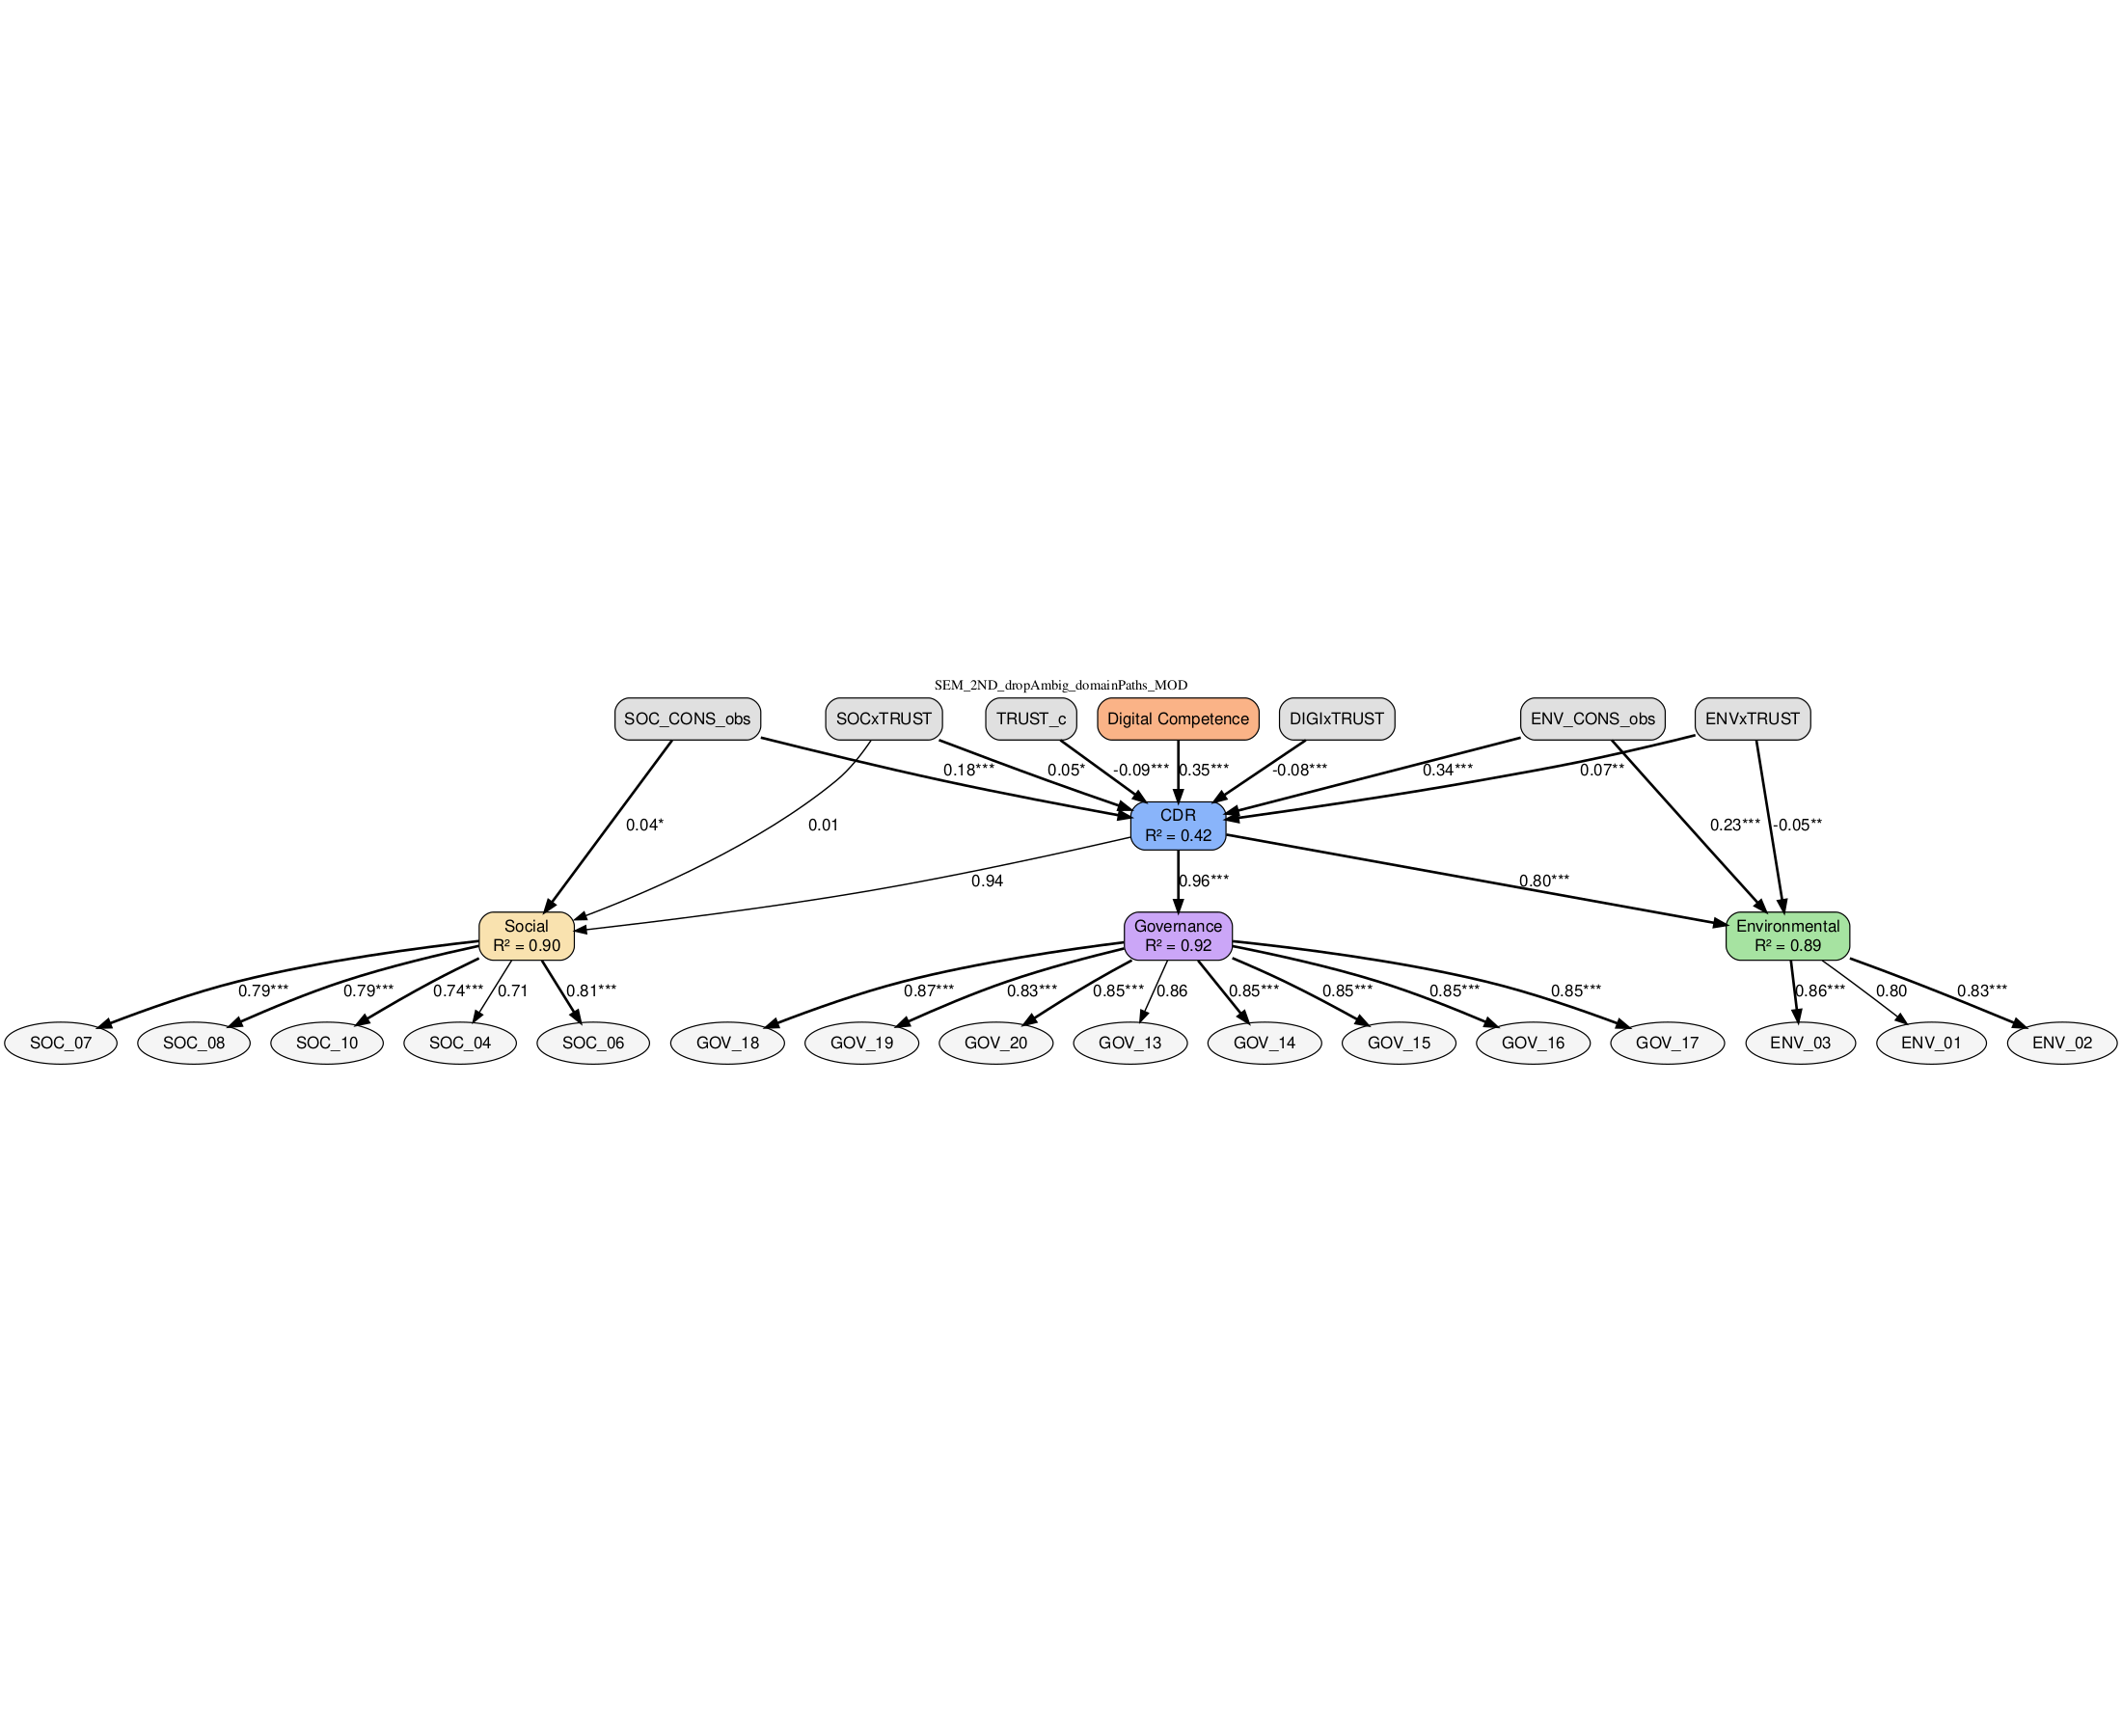

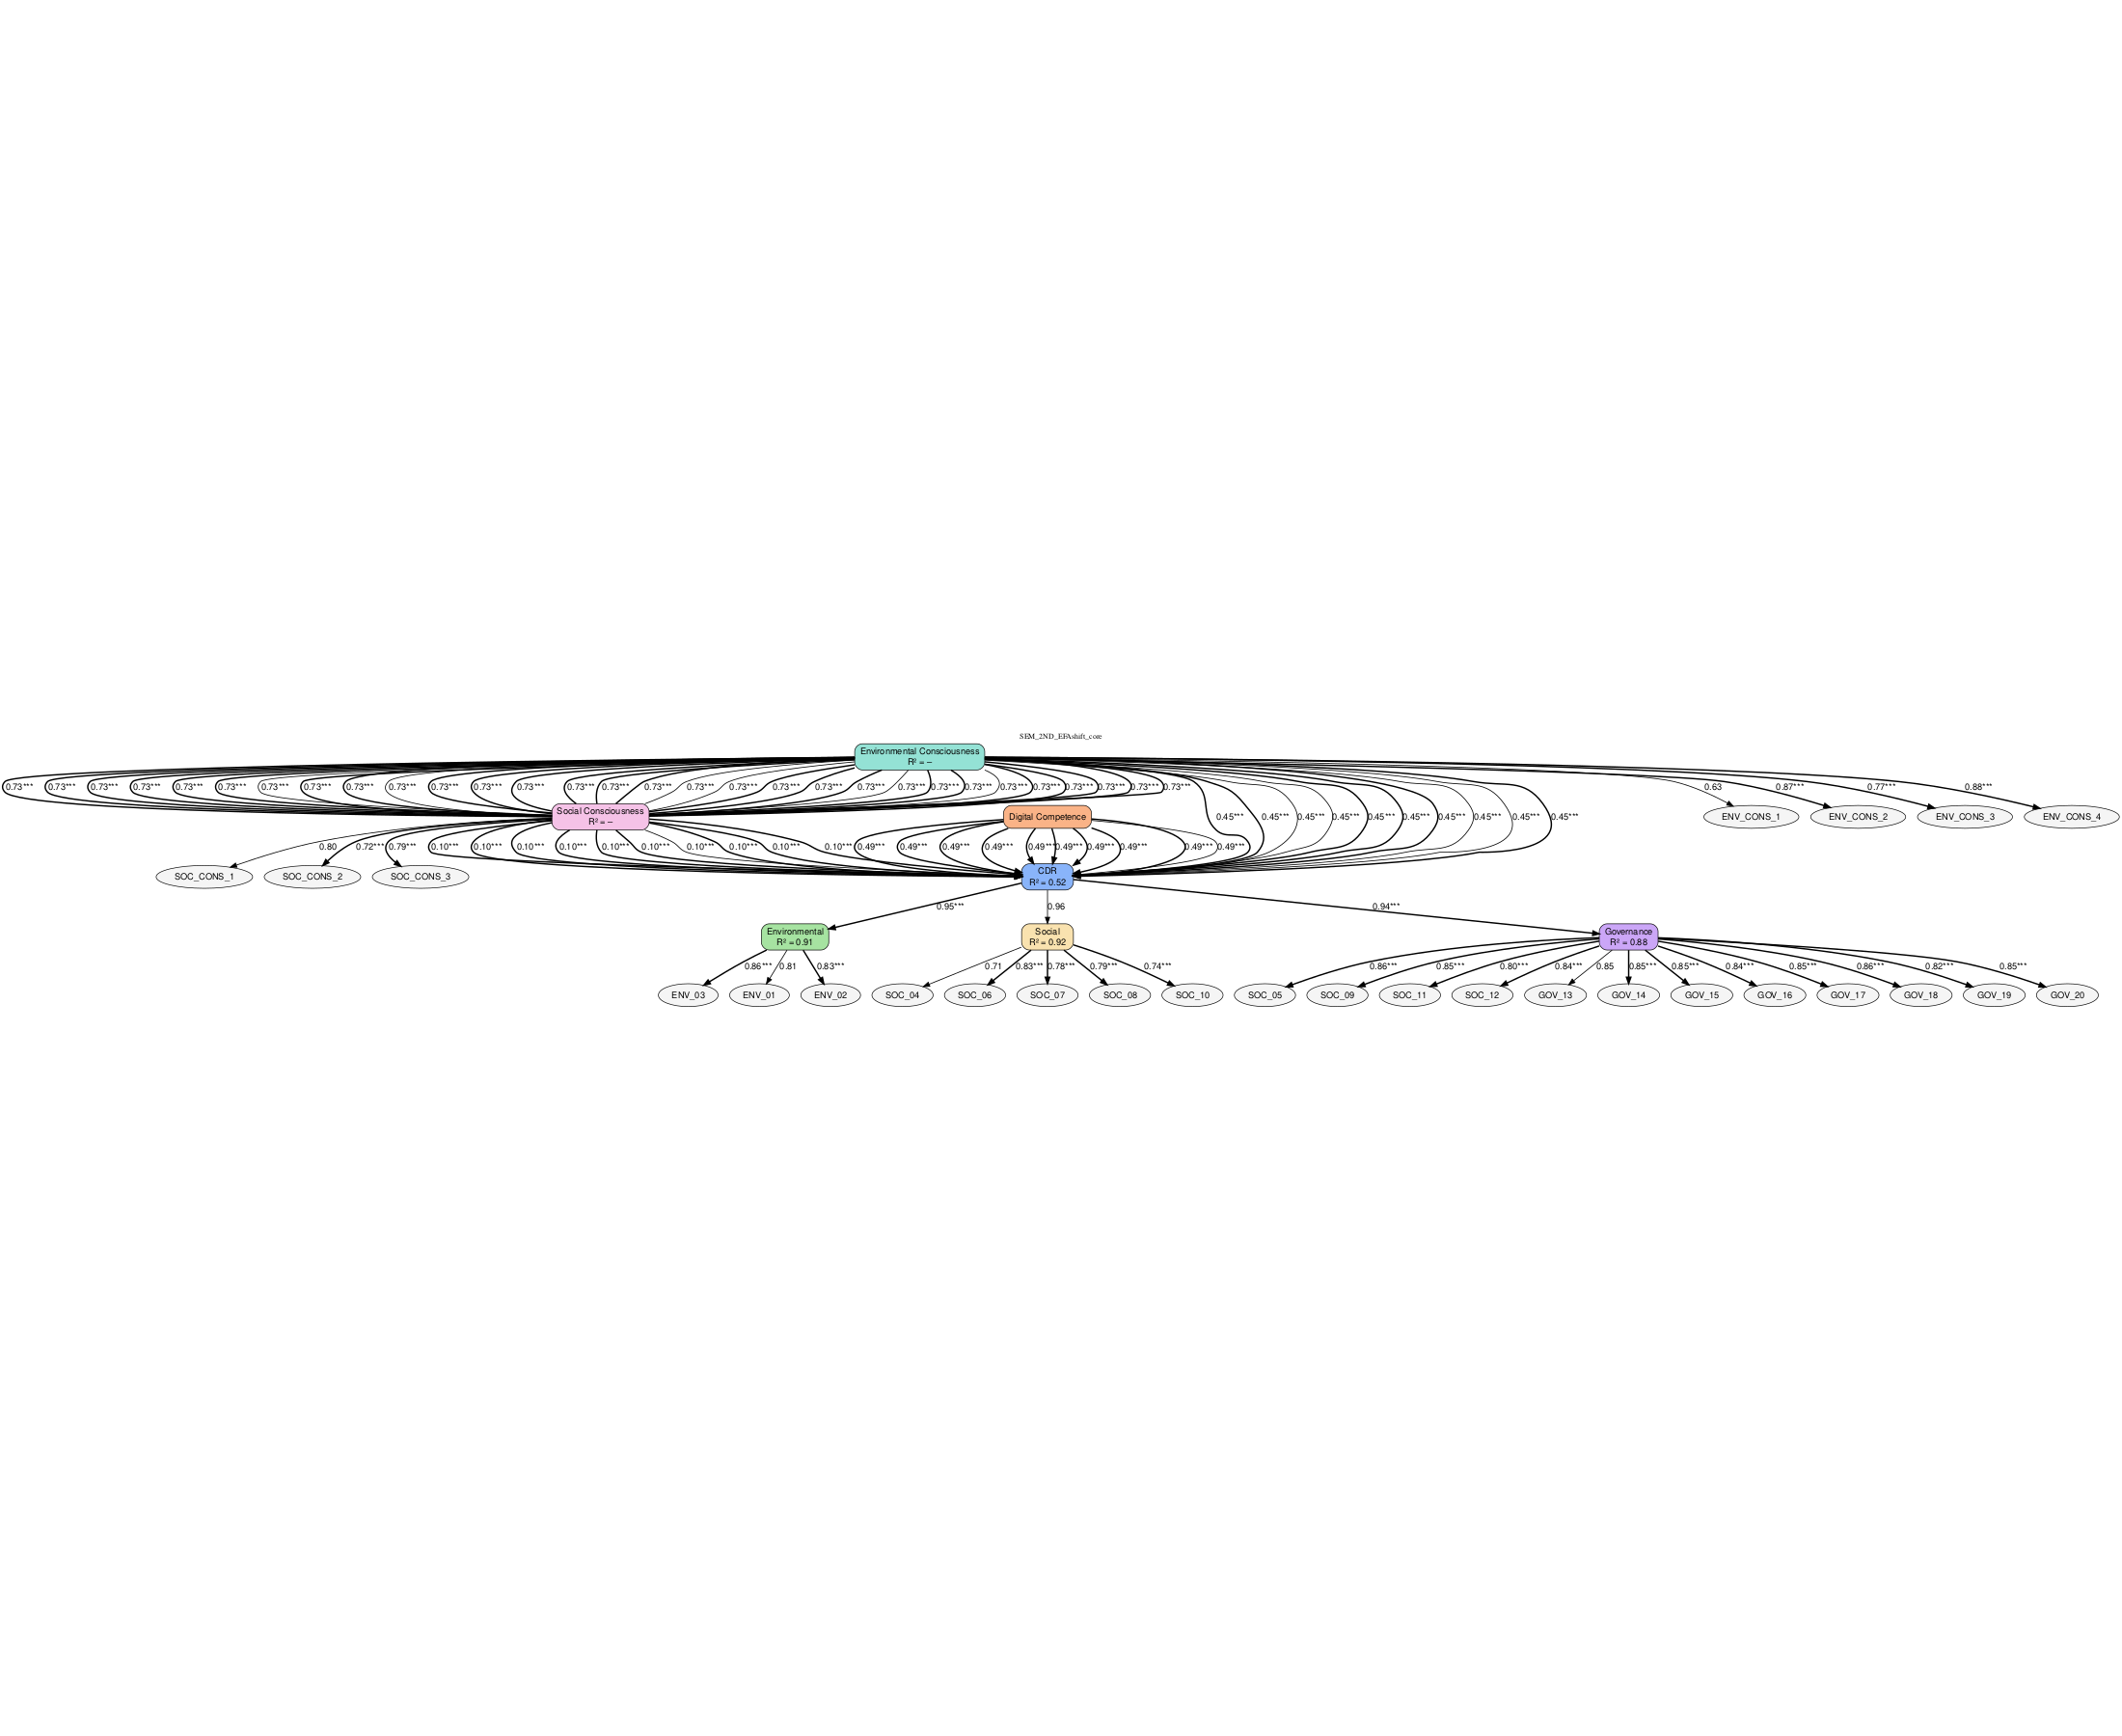

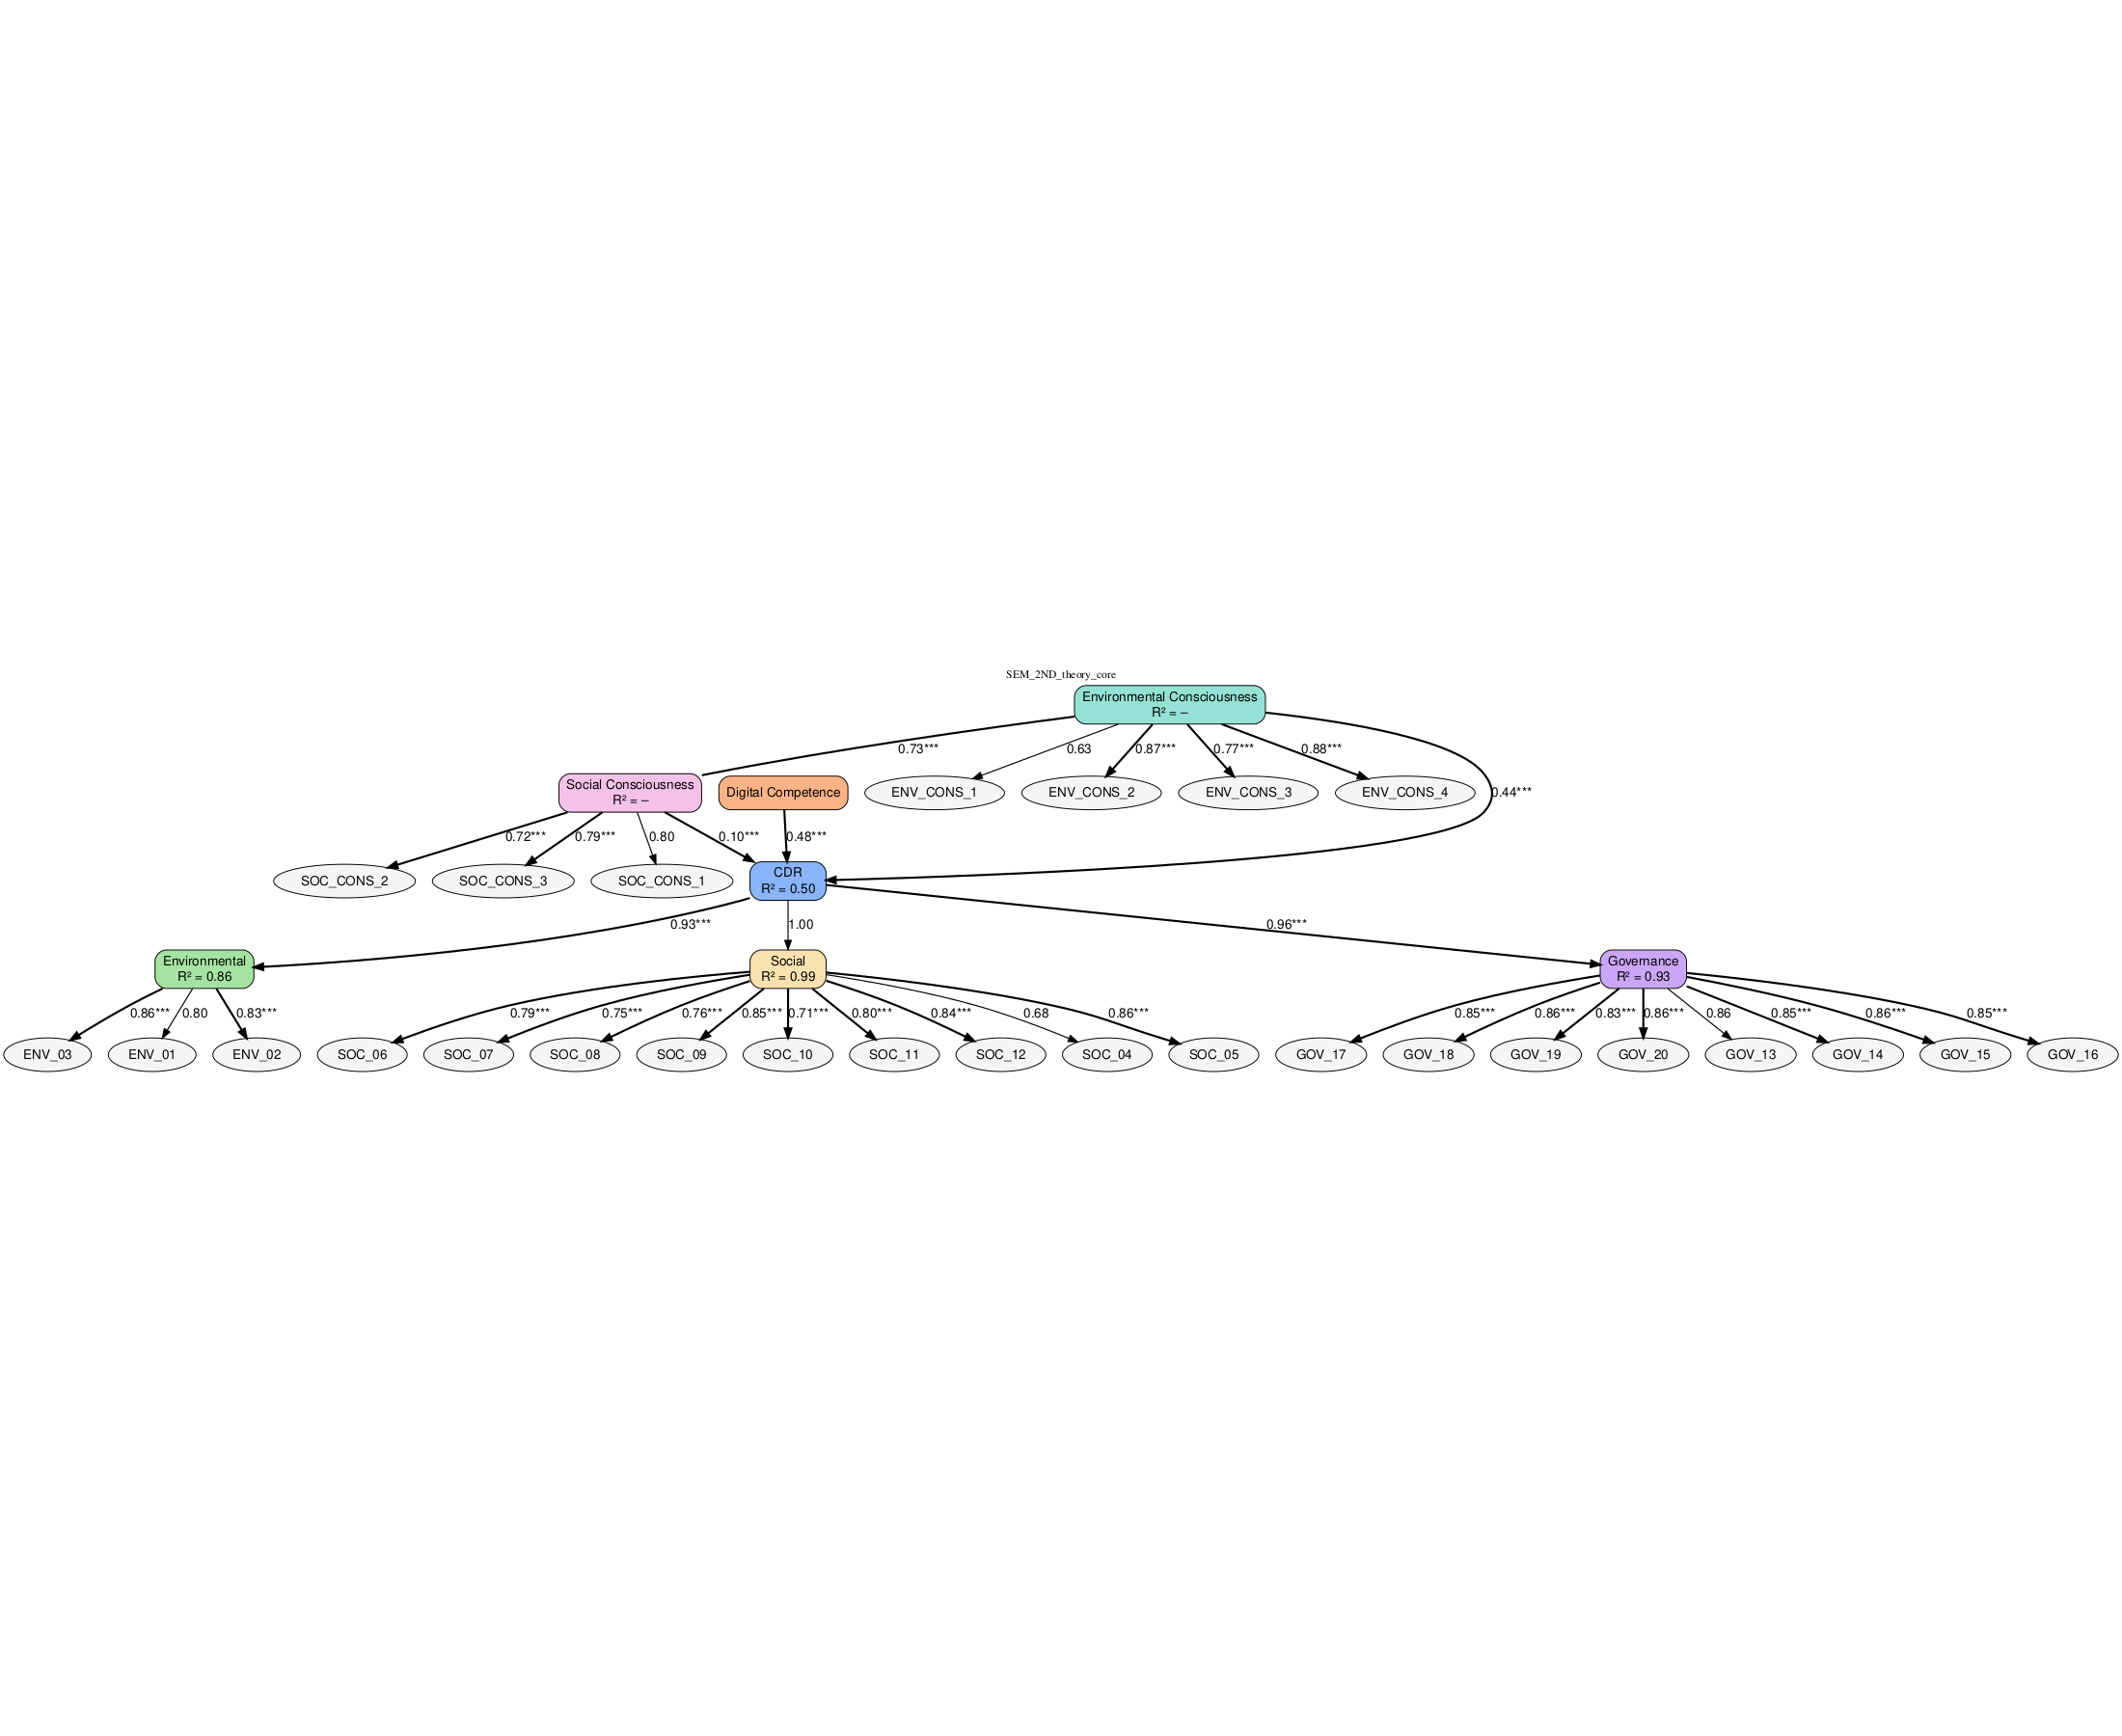

#### graph_SEM_2ND_dropAmbig_core.png 

#### graph_SEM_2ND_dropAmbig_domainPaths.png 

#### graph_SEM_2ND_dropAmbig_domainPaths_MOD.png 

#### graph_SEM_2ND_EFAshift_core.png 

#### graph_SEM_2ND_theory_core.png 



In [33]:
# ================= DISPLAY: comparison, fit stats, key coefficients, images =================
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(knitr)
})

OUT_DIR  <- "out_sem_cdr"
FITS_DIR <- file.path(OUT_DIR, "fits")

read_csv_safe <- function(p) tryCatch(readr::read_csv(p, show_col_types = FALSE), error = function(e) NULL)

hr <- function(txt) {
  cat("\n", paste0(rep("—", nchar(txt) + 4), collapse = ""), "\n",
      "  ", txt, "\n",
      paste0(rep("—", nchar(txt) + 4), collapse = ""), "\n\n", sep = "")
}

show_df <- function(df, caption = NULL, digits = 3) {
  if (is.null(df) || !nrow(df)) { cat("_(no rows)_\n\n"); return(invisible(NULL)) }
  print(knitr::kable(df, format = "markdown", caption = caption, digits = digits))
  cat("\n")
}

# ---- 1) Model comparison ----
hr("Model comparison")
cmp <- read_csv_safe(file.path(FITS_DIR, "sem_compare_all.csv"))
show_df(cmp)

# ---- 2) Full fit statistics per model ----
hr("Full fit statistics per model")

# Core models
fit_core_files <- c(
  "fit_SEM_2ND_theory_core.csv",
  "fit_SEM_2ND_dropAmbig_core.csv"
)

for (ff in fit_core_files) {
  fp <- file.path(FITS_DIR, ff)
  if (file.exists(fp)) {
    nm <- sub("^fit_(.*)\\.csv$", "\\1", ff)
    cat("###", nm, "\n\n")
    show_df(read_csv_safe(fp))
  } else {
    cat("###", ff, " — NOT FOUND\n\n")
  }
}

                                      # NON-MODERATED domain-paths model (RQ3.1 domain effects)
domain_paths_fp <- file.path(FITS_DIR, "paths_SEM_2ND_dropAmbig_domainPaths.csv")
if (file.exists(domain_paths_fp)) {
  df_dom <- read_csv_safe(domain_paths_fp)
  cat("### SEM_2ND_dropAmbig_domainPaths (NON-MOD, RQ3.1 domain paths)\n\n")
  # Show BOTH the higher-order CDR effects AND the domain-specific effects for transparency
  df_dom_filtered <- tryCatch(
    dplyr::filter(df_dom, Outcome %in% c("CDR", "Environmental", "Social")),
    error = function(e) df_dom
  )
  show_df(df_dom_filtered)
} else {
  cat("### SEM_2ND_dropAmbig_domainPaths — NOT FOUND (you may need save_tbl(paths_, ...) for this model)\n\n")
}


# Moderated model fit: prefer fit_* if available, else fallback to sem_fit_moderated_only.csv
mod_fit_preferred <- file.path(FITS_DIR, "fit_SEM_2ND_dropAmbig_domainPaths_MOD.csv")
mod_fit_fallback  <- file.path(FITS_DIR, "sem_fit_moderated_only.csv")

if (file.exists(mod_fit_preferred)) {
  cat("### SEM_2ND_dropAmbig_domainPaths_MOD\n\n")
  show_df(read_csv_safe(mod_fit_preferred))
} else if (file.exists(mod_fit_fallback)) {
  cat("### SEM_2ND_dropAmbig_domainPaths_MOD (fallback: sem_fit_moderated_only.csv)\n\n")
  show_df(read_csv_safe(mod_fit_fallback))
} else {
  cat("### SEM_2ND_dropAmbig_domainPaths_MOD — NO FIT CSV FOUND\n\n")
}

# ---- 3) Key coefficients: predictors → CDR ----
hr("Key coefficients: predictors → CDR")

# Core models (paths_* already filtered to ENV_CONS, SOC_CONS, digiQ_prop)
core_paths <- c(
  "paths_SEM_2ND_theory_core.csv",
  "paths_SEM_2ND_dropAmbig_core.csv"
)
for (pf in core_paths) {
  fp <- file.path(FITS_DIR, pf)
  if (!file.exists(fp)) next
  nm <- sub("^paths_(.*)\\.csv$", "\\1", pf)
  df <- read_csv_safe(fp)
  if (!is.null(df)) {
    df_cdr <- tryCatch(dplyr::filter(df, Outcome == "CDR"), error = function(e) df)
    cat("###", nm, "\n\n")
    show_df(df_cdr)
  }
}

# Moderated model: use ALL paths and filter to Outcome == 'CDR'
mod_all_fp <- file.path(FITS_DIR, "paths_ALL_SEM_2ND_dropAmbig_domainPaths_MOD.csv")
if (file.exists(mod_all_fp)) {
  dfm <- read_csv_safe(mod_all_fp)
  cat("### SEM_2ND_dropAmbig_domainPaths_MOD — CDR only\n\n")
  dfm_cdr <- tryCatch(dplyr::filter(dfm, Outcome == "CDR"), error = function(e) dfm)
  show_df(dfm_cdr)
}

# (Optional) Domain paths from moderated model
if (file.exists(mod_all_fp)) {
  dfm <- read_csv_safe(mod_all_fp)
  cat("### SEM_2ND_dropAmbig_domainPaths_MOD — domain outcomes (Environmental, Social)\n\n")
  dfm_dom <- tryCatch(dplyr::filter(dfm, Outcome %in% c("Environmental","Social")), error = function(e) NULL)
  show_df(dfm_dom)
}

# ---- 4) (Optional) Loadings tables ----
hr("Loadings (first- and second-order)")
loads_1 <- list.files(FITS_DIR, pattern = "^loads_.*\\.csv$", full.names = TRUE)
loads_2 <- list.files(FITS_DIR, pattern = "^loads_second_.*\\.csv$", full.names = TRUE)

if (length(loads_1)) {
  cat("### First-order loadings\n\n")
  for (lp in sort(loads_1)) {
    nm <- sub("^loads_(.*)\\.csv$", "\\1", basename(lp))
    cat("####", nm, "\n\n"); show_df(read_csv_safe(lp))
  }
} else cat("_No first-order loadings found._\n\n")

if (length(loads_2)) {
  cat("### Second-order loadings\n\n")
  for (lp in sort(loads_2)) {
    nm <- sub("^loads_second_(.*)\\.csv$", "\\1", basename(lp))
    cat("####", nm, "\n\n"); show_df(read_csv_safe(lp))
  }
} else cat("_No second-order loadings found._\n\n")

# ---- 5) Diagrams (ONLY selected; BiFactor EXCLUDED) ----
hr("Diagrams")
selected_graphs <- c(
  "graph_SEM_2ND_dropAmbig_core.png",
  "graph_SEM_2ND_dropAmbig_domainPaths.png",
  "graph_SEM_2ND_dropAmbig_domainPaths_MOD.png",
  "graph_SEM_2ND_EFAshift_core.png",
  "graph_SEM_2ND_theory_core.png"
)

any_found <- FALSE
for (fname in selected_graphs) {
  fpath <- file.path(OUT_DIR, fname)
  if (file.exists(fpath)) {
    any_found <- TRUE
    cat("####", fname, "\n")
    if (requireNamespace("IRdisplay", quietly = TRUE)) {
      IRdisplay::display_png(file = fpath)
    } else {
      print(knitr::include_graphics(fpath))
    }
    cat("\n")
  } else {
    cat("⚠️ File NOT FOUND:", fname, "\n\n")
  }
}
if (!any_found) cat("_No selected diagrams found in_", OUT_DIR, "\n")
